<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [19]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [20]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [21]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [22]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


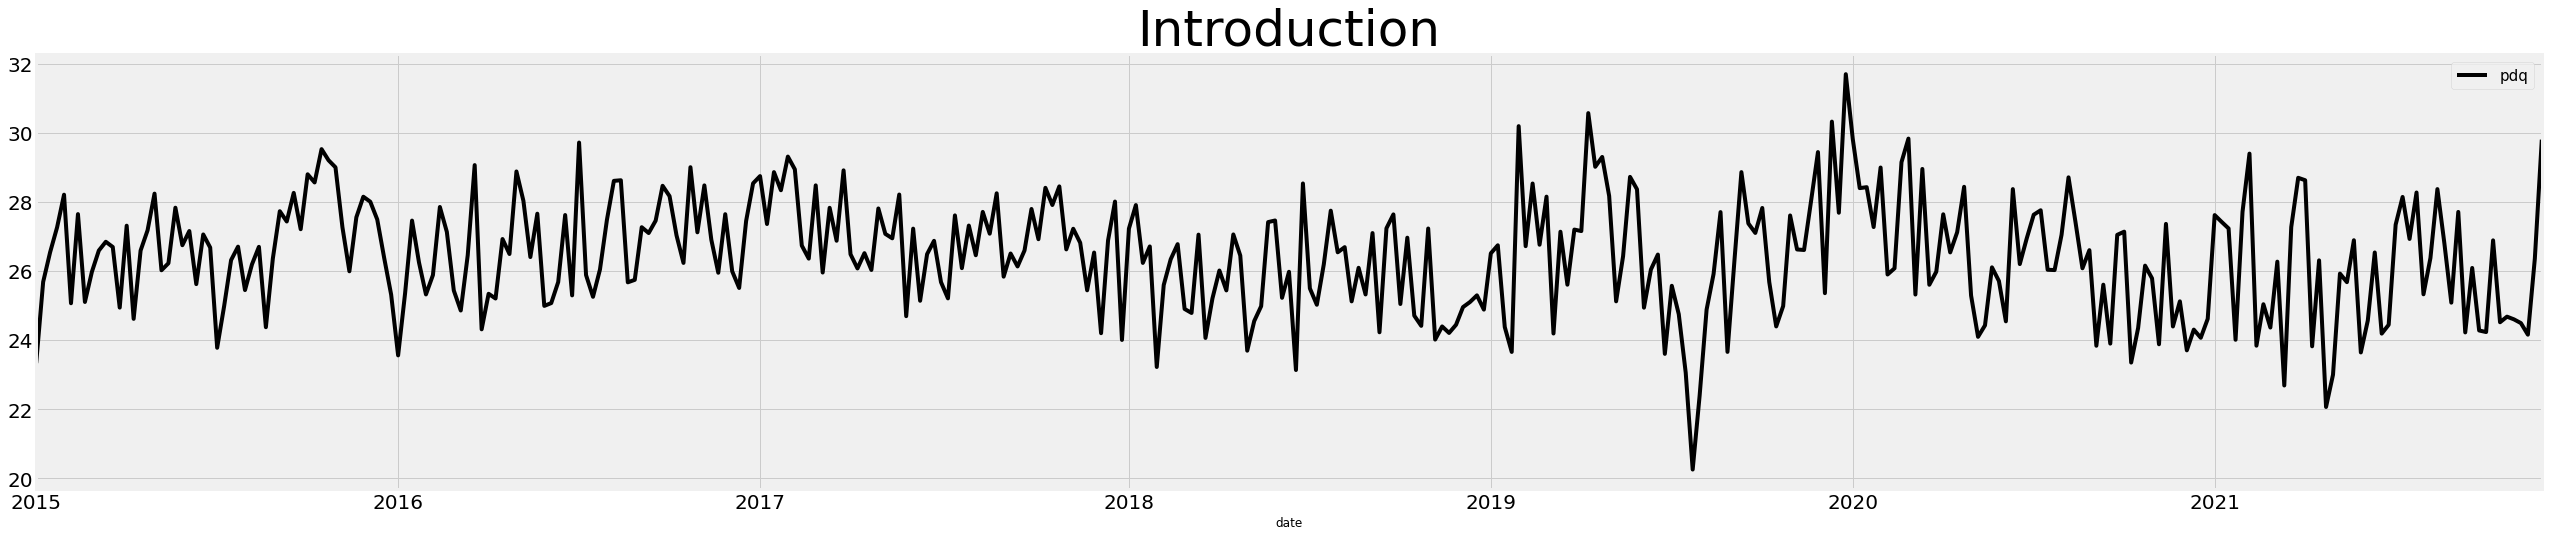

In [23]:
# s=1
y_s1.plot(figsize=(40, 8),color = 'black',fontsize=20)
titulo = validate_categorie[0]
plt.legend(fontsize=15)
plt.title(titulo,fontsize=50)
plt.show()

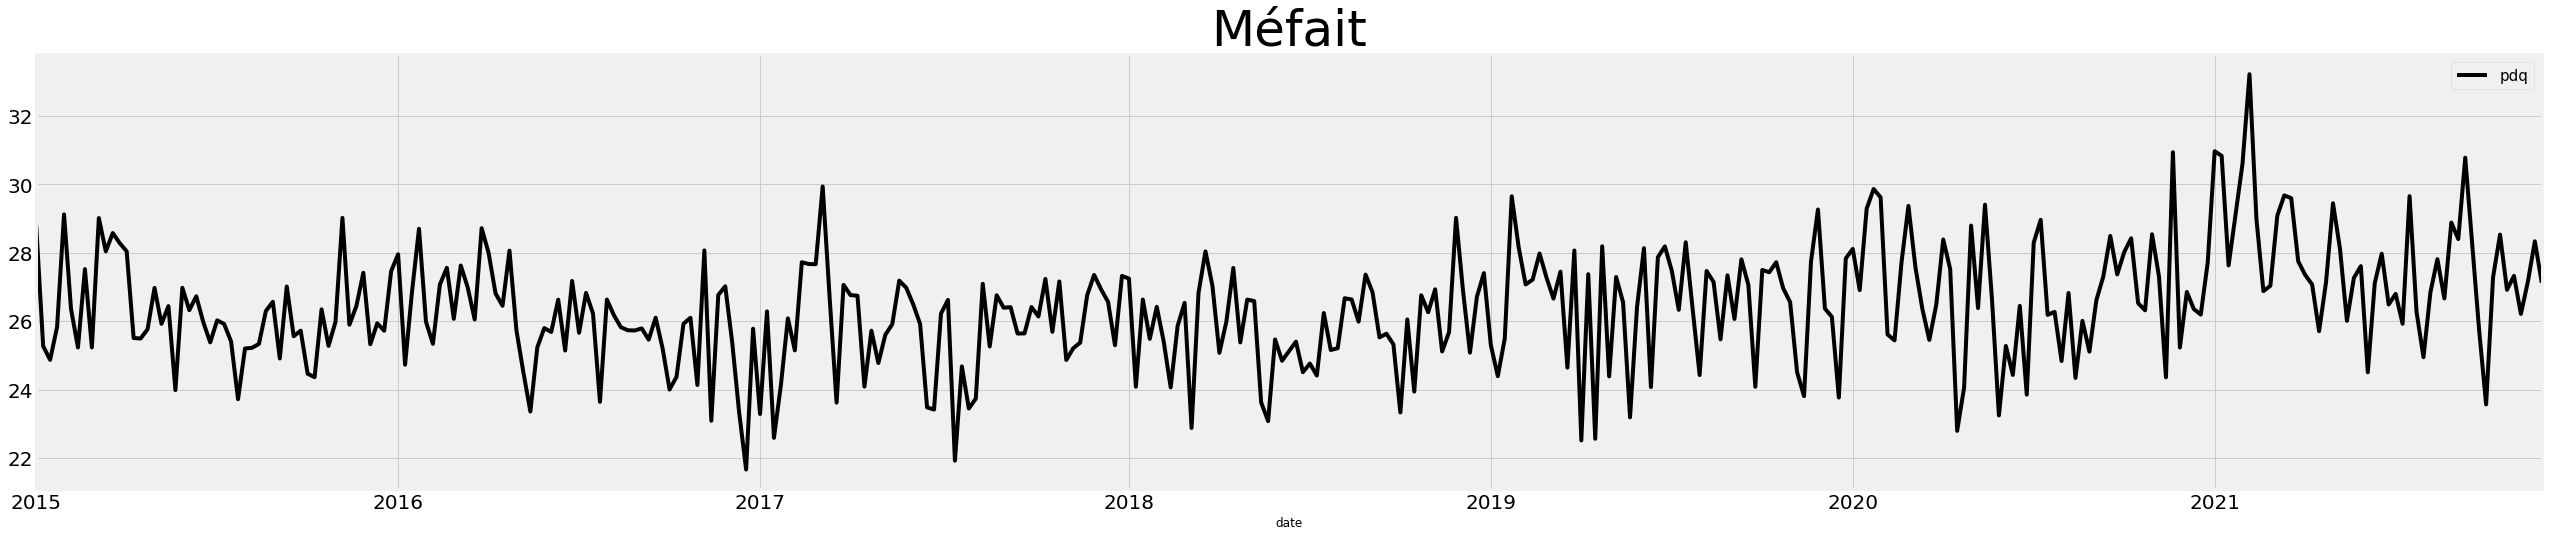

In [24]:
# s=2
y_s2.plot(figsize=(40, 8),color = 'black',fontsize=20)
titulo = validate_categorie[1]
plt.legend(fontsize=15)
plt.title(titulo,fontsize=50)
plt.show()

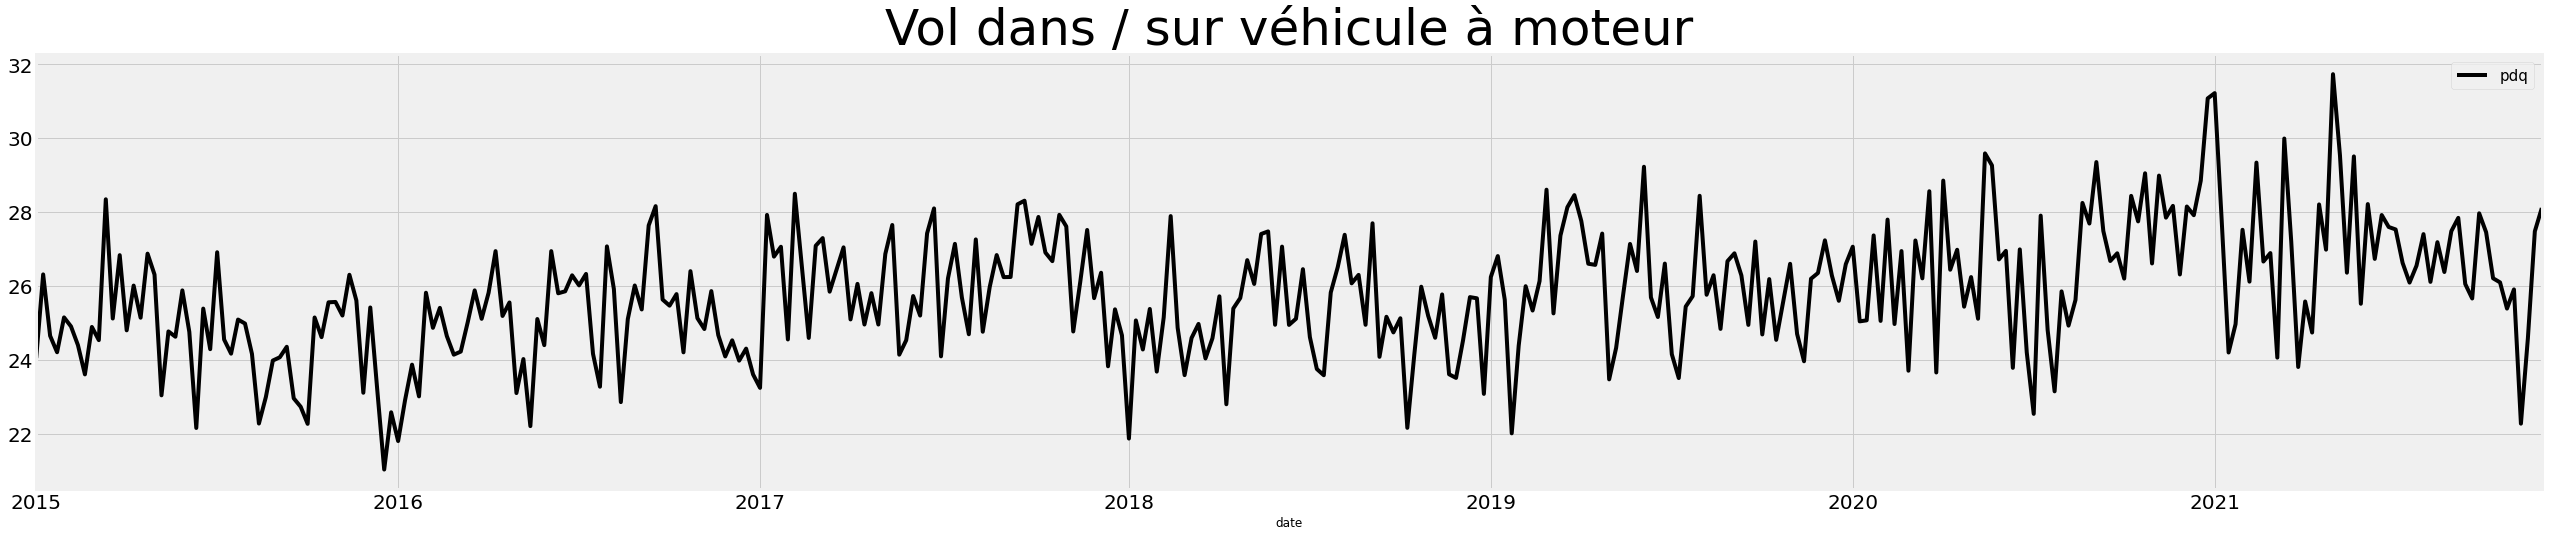

In [25]:
# s=3
y_s3.plot(figsize=(40, 8),color = 'black',fontsize=20)
titulo = validate_categorie[2]
plt.legend(fontsize=15)
plt.title(titulo,fontsize=50)
plt.show()

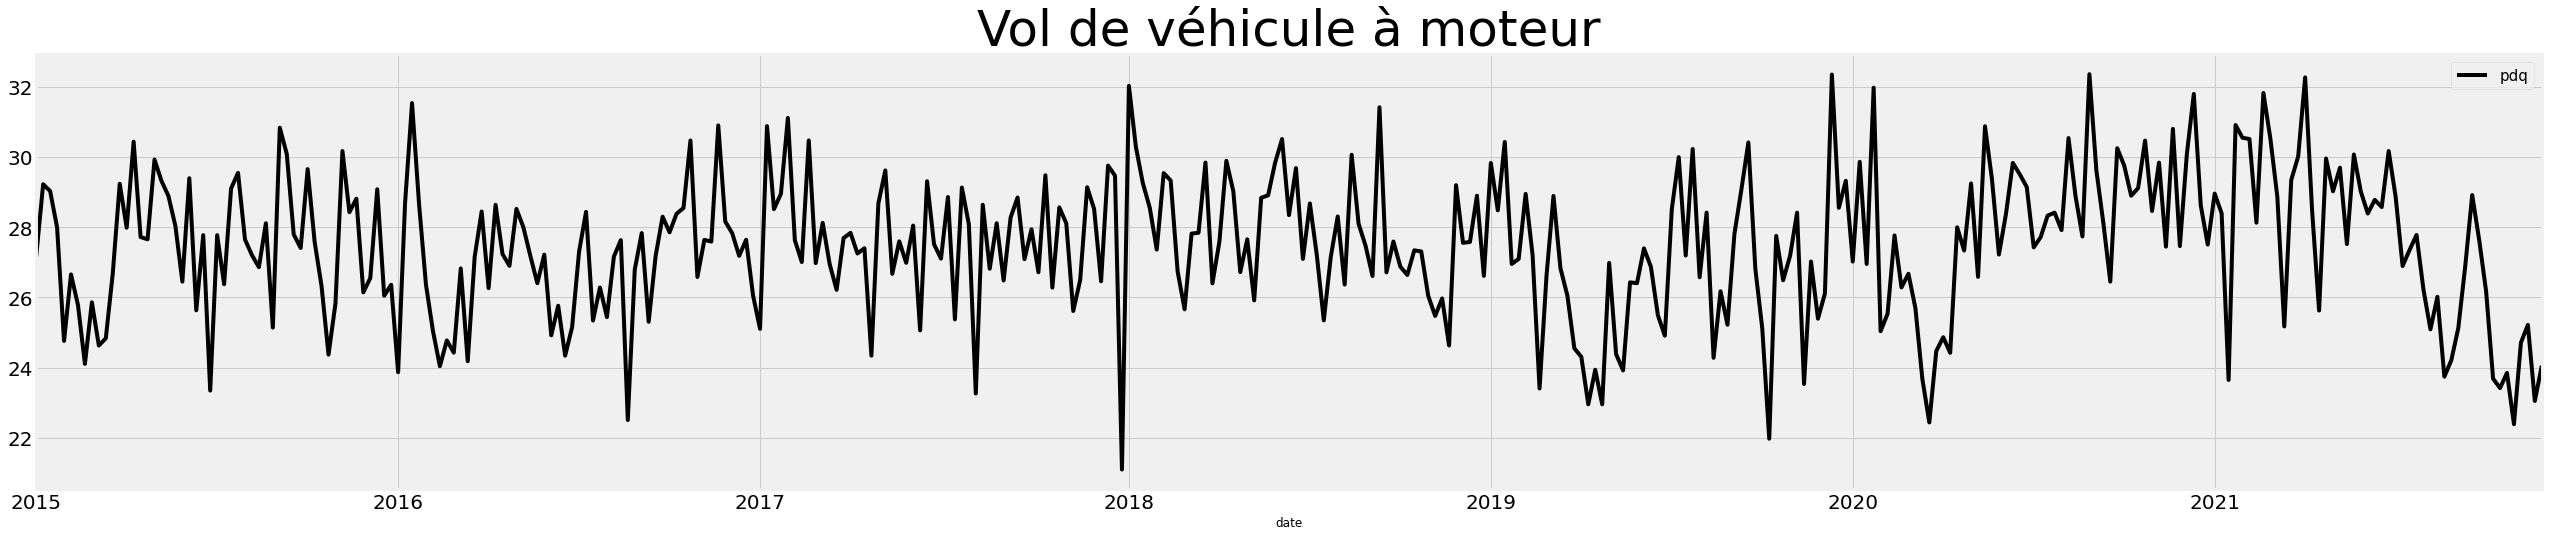

In [26]:
# s=4
y_s4.plot(figsize=(40, 8),color = 'black',fontsize=20)
titulo = validate_categorie[3]
plt.legend(fontsize=15)
plt.title(titulo,fontsize=50)
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [42]:
df = y_s2
df.head()

,pdq
date,
2015-01-04,28.803030
2015-01-11,25.270073
2015-01-18,24.867257
2015-01-25,25.828571
2015-02-01,29.120000


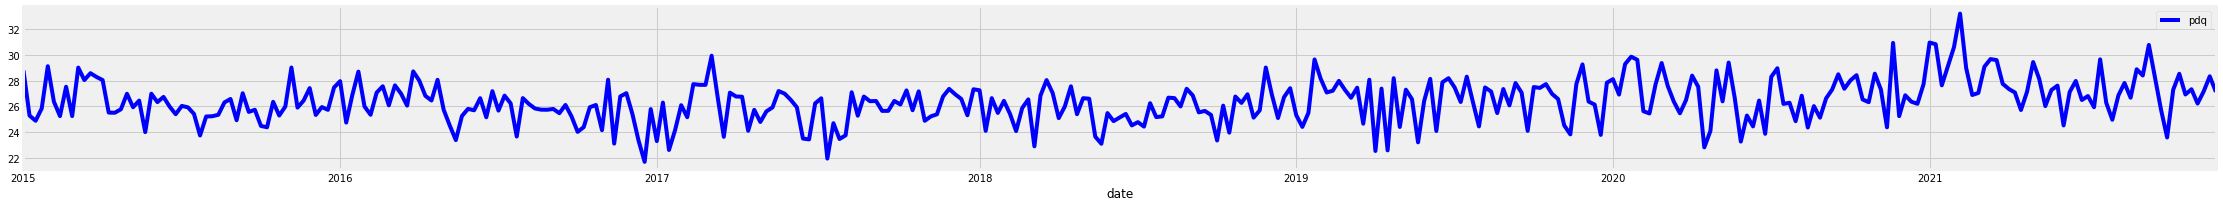

In [43]:
# graficar datos
df.plot(figsize=(35, 3),color = 'blue')
plt.show()

Diagrama box-plot por año

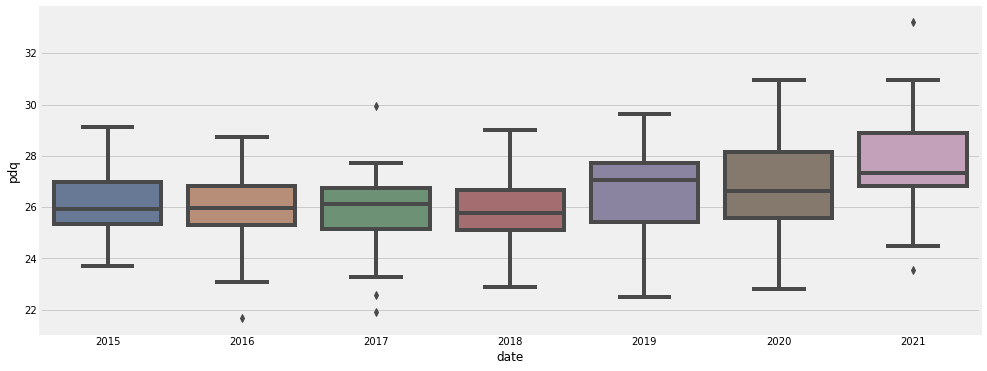

In [44]:
# diagrama de caja y bigotes
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x = df.index.year, y = df.pdq, ax=ax)
plt.show()

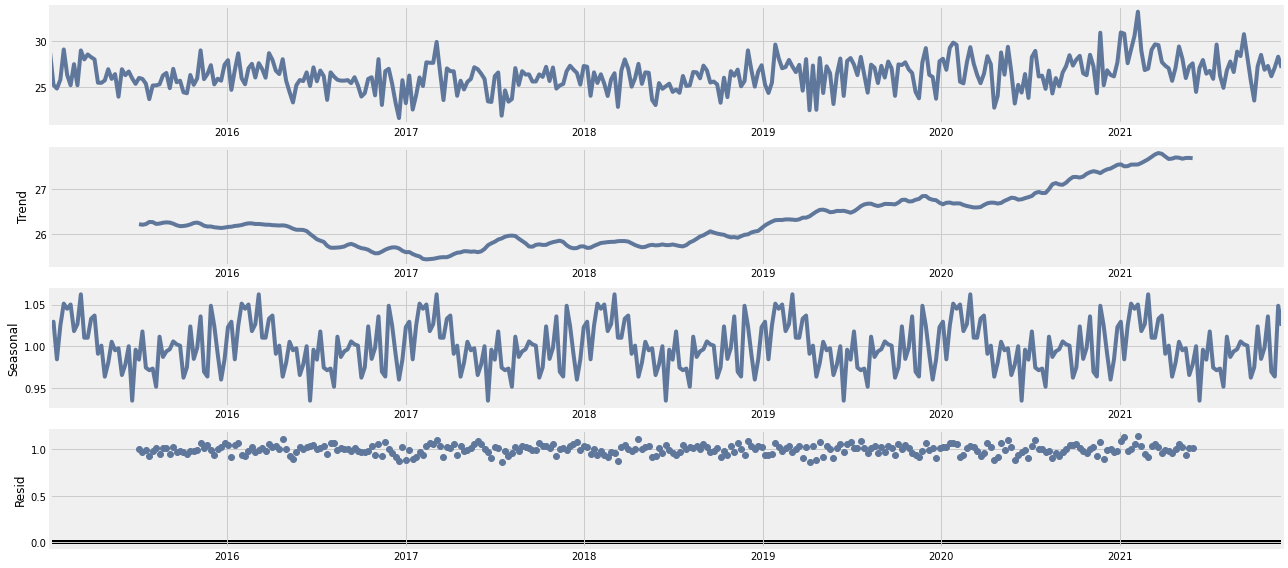

In [45]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = decomposition.plot()
plt.show()

Analizando cada uno de los gráficos

**- Gráfico 1:** Muestra la variable original

**- Gráfico 2:** Muestra la tendencia de la serie, en este caso la tendencia varia con los años, siendo positiva y negativa en distintos tramos.

**- Gráfico 3:** Este gráfico muestra la estacionariedad, es decir, patrones de comportamiento que se repiten con una cierta frecuencia en la serie.

**- Gráfico 4:** Este gráfico muestra el error de la serie.


Autocorrelación (ACF) y autocorrelación parcial PACF

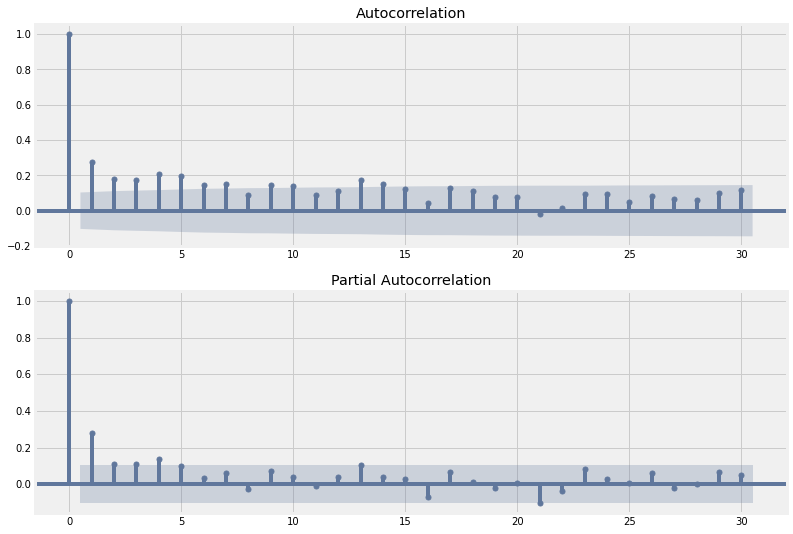

In [46]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(df.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(df.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una rápida disminución de la correlación después de un pequeño retraso entre los puntos. 

A continuación, se realizara la prueba de Dickey-Fuller.

In [47]:
from statsmodels.tsa.stattools import adfuller

#test Dickey-Fulle:
print ('Resultados del test de Dickey-Fuller:')
dftest = adfuller(df.pdq, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                  -5.434942
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    356.000000
dtype: float64


El valor de p-value es muy bajo, se puede asumir que la serie es estacionaria.

La diferenciación es para las series que no son estacionarias, en caso de no serla se realiza el siguiente procedimiento.

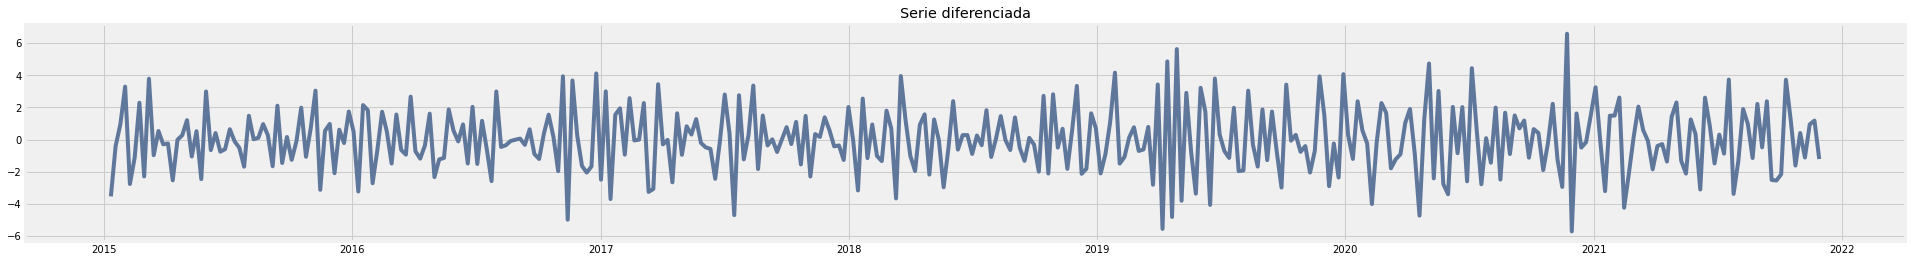

In [48]:
# diferenciacion

Y_diff = df.diff()

rcParams['figure.figsize'] = 30, 4
plt.plot(Y_diff)
plt.title("Serie diferenciada")
plt.show()

In [49]:
def box_transformations(y,param):
    if param>0:
        return y.apply(lambda x: (x**(param)-1)/param)
    elif param==0:
        return np.log(y)
    else:
        print("lambda es negativo, se devulve la serie original")
        return y

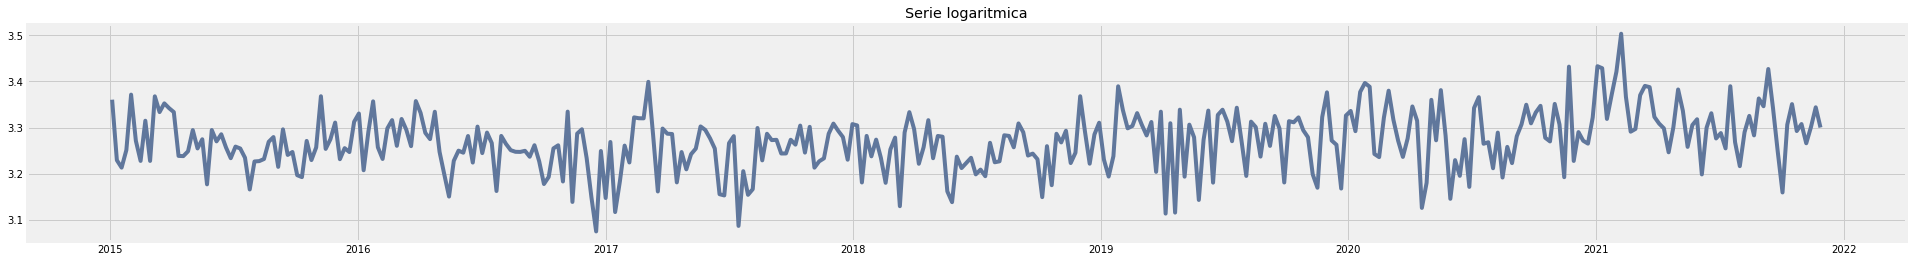

In [50]:
# logaritmo

Y_log = box_transformations(df,0)

rcParams['figure.figsize'] = 30, 4
plt.plot(Y_log)
plt.title("Serie logaritmica")
plt.show()

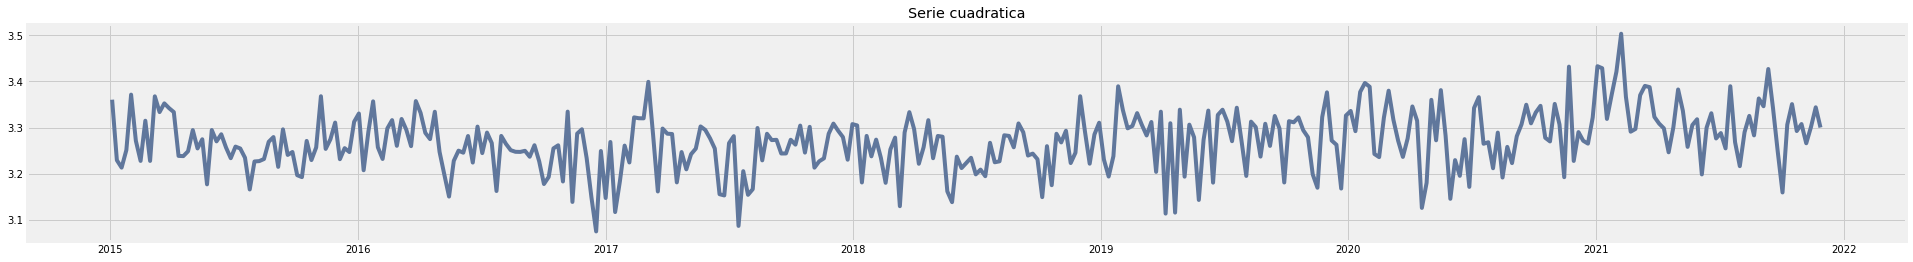

In [51]:
# cuadratica

Y_quad = box_transformations(df,2)

rcParams['figure.figsize'] = 30, 4
plt.plot(Y_log)
plt.title("Serie cuadratica")
plt.show()

Aplicar el modelo de pronóstico  𝑆𝐴𝑅𝐼𝑀𝐴(𝑝,𝑑,𝑞)𝑥(𝑃,𝐷,𝑄,𝑆) , probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.

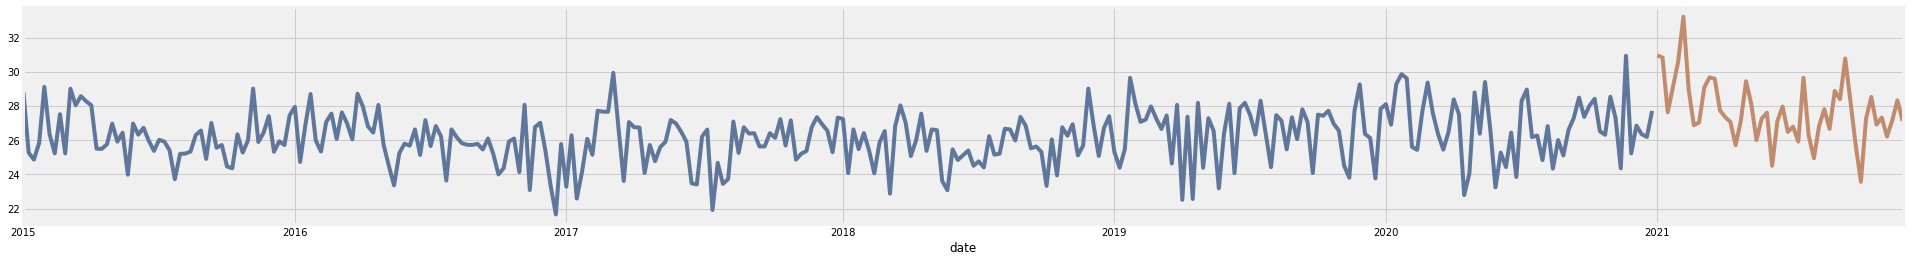

In [68]:
target_date =  '2021-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = df.index < target_date

y_train = df[mask_ds]
y_test = df[~mask_ds]

#plotting the data
y_train['pdq'].plot()
y_test['pdq'].plot()
plt.show()

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import datasets
from sklearn import tree, model_selection
from sklearn.model_selection import train_test_split

# parametros
param = [(1,0,0),(0,0,0,12)]

# modelo
model = SARIMAX(y_train,
                        order=param[0],
                        seasonal_order=param[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
# ajustar modelo
model_fit = model.fit(disp=0)

# fecha de las predicciones        
start_index = y_test.index.min()
end_index = y_test.index.max()

preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

# resultados del ajuste
df_temp.head()

,y,yhat
2021-01-03,30.967742,27.628178
2021-01-10,30.833333,27.542338
2021-01-17,27.629032,27.456764
2021-01-24,29.114754,27.371457
2021-01-31,30.606061,27.286414


In [72]:
# resultados de las métricas
df_metrics = summary_metrics(df_temp)
df_metrics['model'] = f"SARIMA_{param[0]}X{param[1]}".replace(' ','')
df_metrics

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,2.1947,6.982,2.6423,0.077,0.0766,0.0791,0.0743,0.0812,"SARIMA_(1,0,0)X(0,0,0,12)"


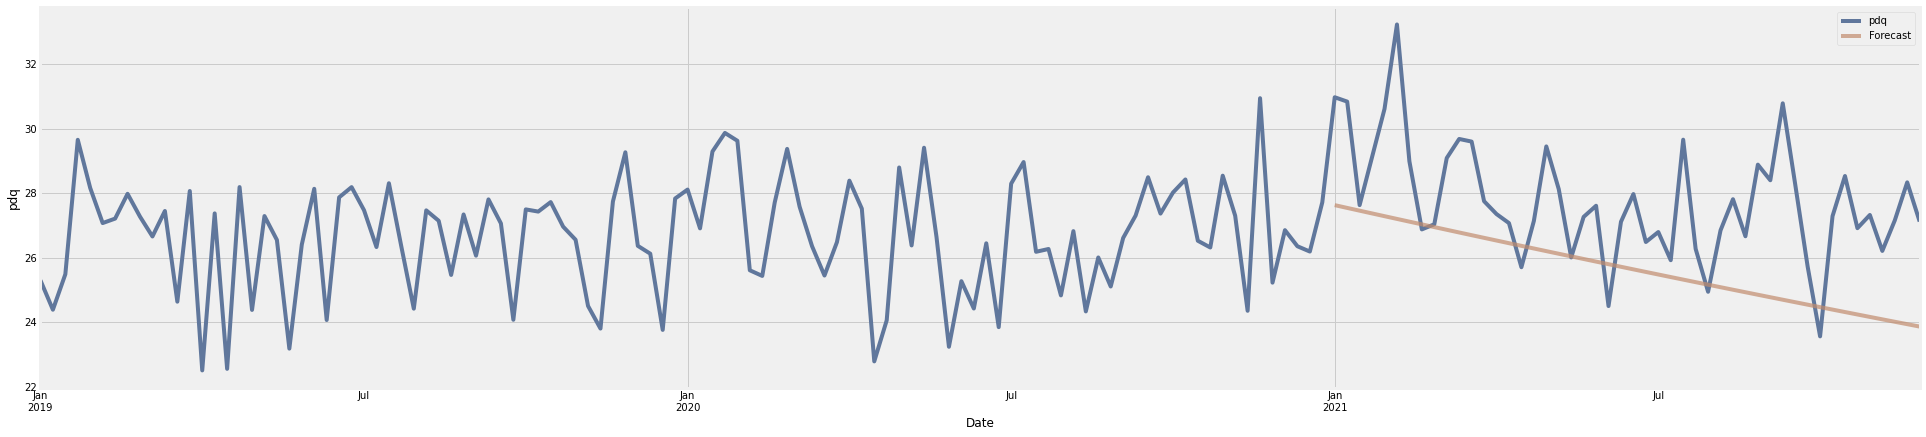

In [76]:
# graficamos resultados

preds = df_temp['yhat']
ax = df['2019':].plot(label='observed') # se elige año 2019 para entrenar
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(30, 7))
ax.set_xlabel('Date')
ax.set_ylabel('pdq')
plt.legend()
plt.show()


In [77]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [78]:
# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [79]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(df,target_date)
        frames.append(df_metrics)
    except:
        pass

C:\Users\56972\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.3551,3.4263,1.8510,0.0478,0.0476,0.0488,0.0461,0.0486,"SARIMA_(1,1,0)X(1,0,1,12)"
0,1.3567,3.4359,1.8536,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,1,12)"
0,1.3584,3.4565,1.8592,0.0479,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(1,0,0,12)"
0,1.3588,3.5038,1.8718,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,0,12)"
0,1.3703,3.1981,1.7883,0.0491,0.0490,0.0494,0.0474,0.0492,"SARIMA_(0,1,0)X(0,0,0,12)"
...,...,...,...,...,...,...,...,...,...
0,3.1468,13.4226,3.6637,0.1107,0.1098,0.1133,0.1069,0.1192,"SARIMA_(1,1,0)X(1,1,0,12)"
0,24.1010,618.8685,24.8771,0.8744,0.7022,0.8681,0.8436,1.6744,"SARIMA_(0,0,0)X(0,0,1,12)"
0,24.5214,625.0162,25.0003,0.8893,0.7163,0.8833,0.8581,1.6908,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.5504,762.9708,27.6219,0.9932,0.7814,0.9924,0.9585,1.9794,"SARIMA_(0,0,1)X(0,0,0,12)"


In [81]:
# ajustar mejor modelo

param = [(1,1,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(df,target_date)
best_model = sarima_model.df_testig(df,target_date)
best_model.head()

,y,yhat
2021-01-03,30.967742,26.976727
2021-01-10,30.833333,27.432895
2021-01-17,27.629032,27.297904
2021-01-24,29.114754,27.216431
2021-01-31,30.606061,27.286228


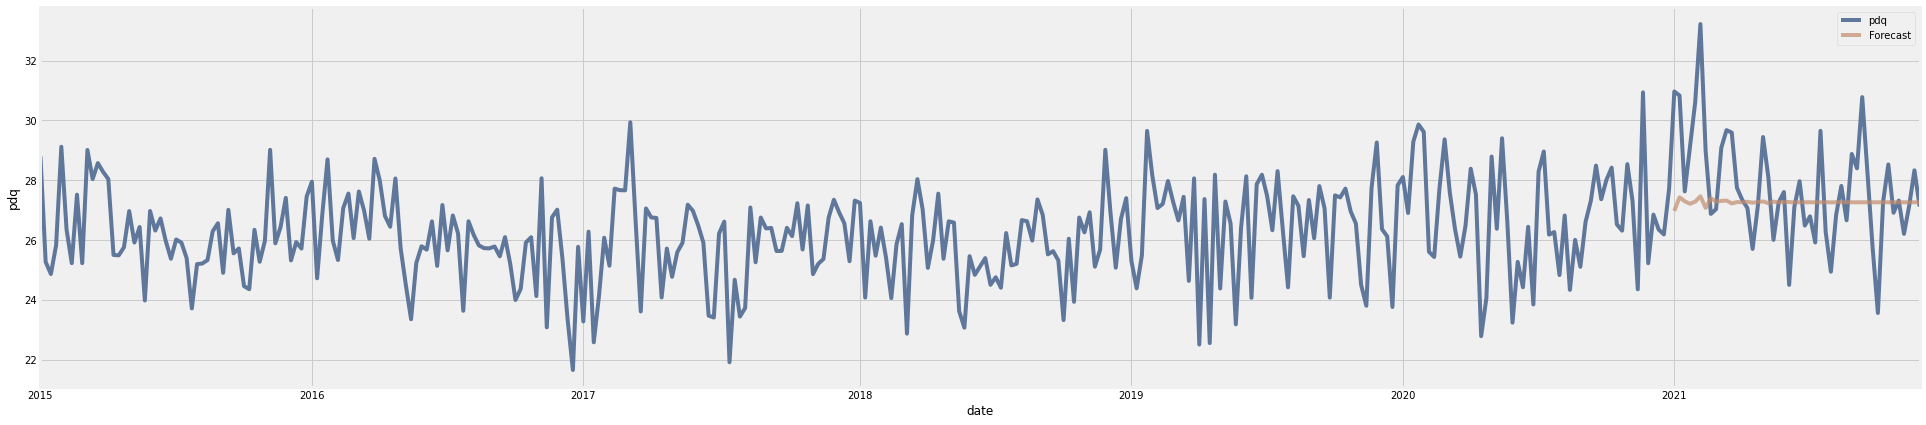

In [86]:
# graficar mejor modelo

preds = best_model['yhat']
ax = df['2015':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(30, 7))
ax.set_xlabel('date')
ax.set_ylabel('pdq')
plt.legend()
plt.show()

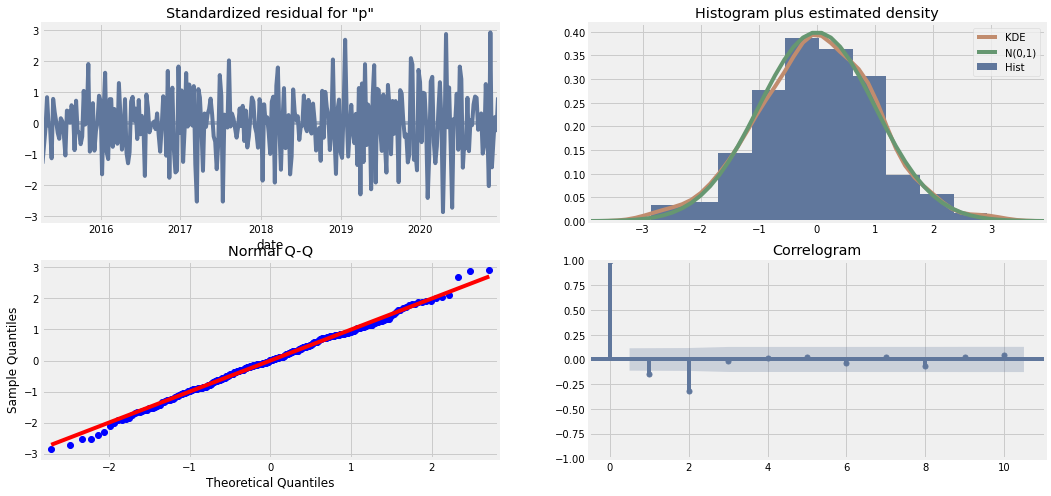

In [65]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

**Comentarios:**

El gráfico obtenido con el método de SARIMAX pareciera no ajustarse bien, tienen una cierta tendencia, pero en amplitud están muy alejados.De los últimos 4 gráficos, el primero indica que el error residual esta oscilando con respecto a cero, lo cual corrobora que la serie si es estacionaria, tal como se mostró anteriormente, el segundo gráfico muestra el histograma del error, donde una distribución normal asociado a una media 0 y desviación estándar 1 es muy similar al error obtenido, lo que corresponde con un ruido blanco, el tercer gráfico, muestra las diferencias entre la distribución de probabilidad de una población de la que se ha extraído una muestra aleatoria y una distribución usada para la comparación. En este caso se comparar la distribución del error versus una distribución normal. Se puede ver que el ajuste lineal es muy bueno, por tanto es más parecida la distribución entre la muestra obtenida y la distribución de prueba (distribución normal). Finalmente, el cuarto gráfico nos muestra el gráfico de autocorrelación entre las variables del error, se observa que no hay correlación entre ninguna de las variables, por lo que se puedan dar indicios de independencia entre las variables.

3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

In [91]:
#conda install -c conda-forge prophet

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\56972\anaconda3

  added / updated specs:
    - prophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.13.0               |     pyhd8ed1ab_0         1.4 MB  conda-forge
    cftime-1.6.1               |   py38hbdcd294_0         163 KB  conda-forge
    conda-4.12.0               |   py38haa244fe_0         1.0 MB  conda-forge
    convertdate-2.4.0          |     pyhd8ed1ab_0          38 KB  conda-forge
    ephem-4.1.3                |   py38h294d835_4         1.3 MB  conda-forge
    hdf4-4.2.13                |       h712560f_2         1.3 MB
    hijri-converter-2.2.4   



==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda




libnetcdf-4.7.3      | 516 KB    | ###1       |  31% 
libnetcdf-4.7.3      | 516 KB    | #####5     |  56% 
libnetcdf-4.7.3      | 516 KB    | ########6  |  87% 
libnetcdf-4.7.3      | 516 KB    | ########## | 100% 

ephem-4.1.3          | 1.3 MB    |            |   0% 
ephem-4.1.3          | 1.3 MB    | 1          |   1% 
ephem-4.1.3          | 1.3 MB    | 4          |   5% 
ephem-4.1.3          | 1.3 MB    | #2         |  13% 
ephem-4.1.3          | 1.3 MB    | ##1        |  21% 
ephem-4.1.3          | 1.3 MB    | ##6        |  27% 
ephem-4.1.3          | 1.3 MB    | ###7       |  37% 
ephem-4.1.3          | 1.3 MB    | ####6      |  47% 
ephem-4.1.3          | 1.3 MB    | #####6     |  56% 
ephem-4.1.3          | 1.3 MB    | ######7    |  68% 
ephem-4.1.3          | 1.3 MB    | ########1  |  82% 
ephem-4.1.3          | 1.3 MB    | #########1 |  91% 
ephem-4.1.3          | 1.3 MB    | #########9 |  99% 
ephem-4.1.3          | 1.3 MB    | ########## | 100% 

m2w64-bzip2-1.0.6    | 102

prophet-1.0.1        | 580 KB    |            |   0% 
prophet-1.0.1        | 580 KB    | 2          |   3% 
prophet-1.0.1        | 580 KB    | #6         |  17% 
prophet-1.0.1        | 580 KB    | ###3       |  33% 
prophet-1.0.1        | 580 KB    | ######     |  61% 
prophet-1.0.1        | 580 KB    | #######7   |  77% 
prophet-1.0.1        | 580 KB    | ########## | 100% 
prophet-1.0.1        | 580 KB    | ########## | 100% 

hdf4-4.2.13          | 1.3 MB    |            |   0% 
hdf4-4.2.13          | 1.3 MB    | ##         |  21% 
hdf4-4.2.13          | 1.3 MB    | ####1      |  42% 
hdf4-4.2.13          | 1.3 MB    | #########6 |  96% 
hdf4-4.2.13          | 1.3 MB    | ########## | 100% 

conda-4.12.0         | 1.0 MB    |            |   0% 
conda-4.12.0         | 1.0 MB    | 1          |   2% 
conda-4.12.0         | 1.0 MB    | #3         |  14% 
conda-4.12.0         | 1.0 MB    | ##6        |  26% 
conda-4.12.0         | 1.0 MB    | ####1      |  42% 
conda-4.12.0         | 1.0

In [92]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [93]:
# rename 
y_train_prophet = df_train.reset_index()
y_train_prophet.columns = ["pdq"]

y_test_prophet = df_test.reset_index()
y_test_prophet.columns = ["pdq"]

In [94]:
# model
m = Prophet()
m.fit(y_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)['pdq']
forecast.tail()

,ds,yhat
1768,2024-12-22,28.204659
1769,2024-12-23,28.218200
1770,2024-12-24,28.239654
1771,2024-12-25,28.268426
1772,2024-12-26,28.303775


In [96]:
# metrics
result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
summary_metrics(result)

,mae,mse,rmse,mape,maape,wmape,mmape,smape
0,1.2738,2.9681,1.7228,0.0447,0.0446,0.0459,0.0432,0.0457


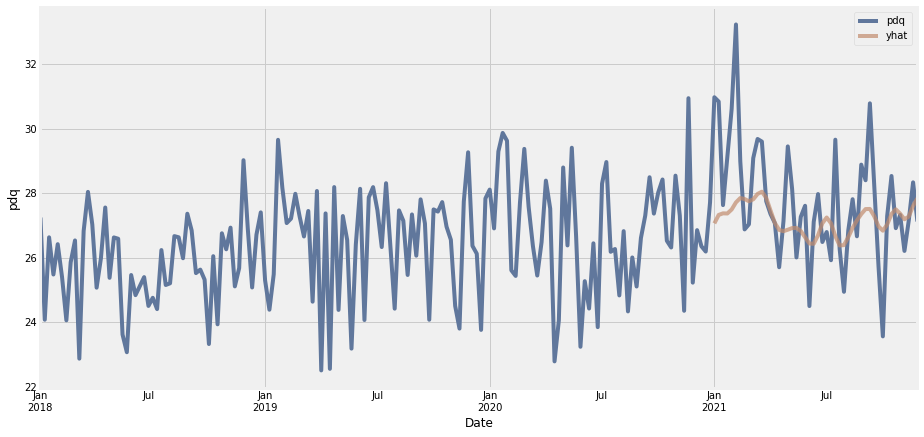

In [98]:
preds = result[['ds','yhat']].set_index("ds")
ax = df['2018':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('pdq')
plt.legend()
plt.show()

**Comentarios:**
No pude descargar esta libreria. El gráfico muestra un ajuste algo mejor que el que se obtuvo con el método anterior de SARIMA, pero de igual forma no se parece mucho a la curva original, al menos en amplitud, la frecuencia de la serie original es más alta.